In [59]:
!conda info --env

# conda environments:
#
jupyter-env           *  /home/FYP/quang012/.conda/envs/jupyter-env
base                     /tc1apps/anaconda3



In [60]:
# All imports go here

import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from typing import Dict, List
from torch.utils.data import DataLoader
import xgboost as xgb
import matplotlib.pyplot as plt
import os
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import transforms
import pandas as pd
import numpy as np
import copy
import random
import time
#from numba import jit
from tqdm import tqdm
from scipy import stats
import torch.optim.lr_scheduler as lr_scheduler

# import TPE sampler
from optuna.samplers import TPESampler

# Hiding the warnings
warnings.filterwarnings('ignore')


In [61]:
# We set the general parameters here

# Can be used if run iteratively but should be avoided
SKIP_OPTUNA = False
SKIP_DATA_LOADING = False


N_TRIALS = 10
TEST_PERCENTAGE = 20 # [1, 100]

gamma_ = 0.95

FOLDER_PREFIX = "small" # reference to model size for identification and plots

CLASSES = 3

# Placeholders
MISTAKE_PERCENTAGE = 0 # for the NN param search
ALPHA = "Placeholder"
LAMBDA_PARAM = "Placeholder"
DAMPEN_LIMIT = "Placeholder"
TOLERANCE = "Placeholder"
PERCENTILE ="Placeholder"
ERROR_SCENARIO = "label"

In [62]:
# All functions go here

# set random seeds for random, numpy and torch
SEED = 42
BATCHSIZE = 1024
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
sampler = TPESampler(seed=SEED)  # Make the sampler behave in a deterministic way.


def convert_boolean_to_int(df):
    for column in df.columns:
        if df[column].dtype == bool:
            df[column] = df[column].astype(int)
    return df

def define_model(trial):
    # We optimize the number of layers, hidden units, and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 3, 3, step=1)

    layers = []

    in_features = X_train.shape[1]  # Input feature size based on X_train

    out_features = trial.suggest_int("n_units", 100, 100, step=50)

    for i in range(int(n_layers)):

        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.BatchNorm1d(out_features))  # Add BatchNorm1d layer
        layers.append(nn.ReLU())

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)

def get_custom_dataset(X, y):
    # Convert the dataframes to PyTorch tensors
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    custom_dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=BATCHSIZE, shuffle=False)

    return data_loader

def objective(trial):
    # Generate the model.
    global model
    model = define_model(trial).to(DEVICE)

    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    l2_pen = trial.suggest_float("l2_pen", 1e-6, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_pen)

    EPOCHS = trial.suggest_int("epochs", 25, 25, step=5)

    # Get the custom dataset.
    # split X_train and y_train_class into train and validation sets
    X_Train, X_Val, y_Train_class, y_Val_class = train_test_split(X_train, y_train_class, test_size=0.2, random_state=42) # CHANGED

    train_loader = get_custom_dataset(X_Train, y_Train_class)
    valid_loader = get_custom_dataset(X_Val, y_Val_class)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma_)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        scheduler.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

def callback(study, trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

class ParameterPerturber:
    def __init__(
        self,
        model,
        opt,
        device,
        parameters,
    ):
        self.model = model.to(device)
        self.opt = opt
        self.alpha = parameters["selection_weighting"]
        self.xmin = None
        self.device = device

        self.lower_bound = 1
        self.exponent = 1
        self.magnitude_diff = None  # unused
        self.min_layer = -1
        self.max_layer = -1
        self.forget_threshold = 1  # unused
        self.dampening_constant = parameters["dampening_constant"]
        self.selection_weighting = parameters["selection_weighting"]

    def get_layer_num(self, layer_name: str) -> int:
        layer_id = layer_name.split(".")[1]
        if layer_id.isnumeric():
            return int(layer_id)
        else:
            return -1

    def zerolike_params_dict(self, model: torch.nn) -> Dict[str, torch.Tensor]:
        """
        Taken from: Avalanche: an End-to-End Library for Continual Learning - https://github.com/ContinualAI/avalanche
        Returns a dict like named_parameters(), with zeroed-out parameter valuse
        Parameters:
        model (torch.nn): model to get param dict from
        Returns:
        dict(str,torch.Tensor): dict of zero-like params
        """
        return dict(
            [
                (k, torch.zeros_like(p, device=p.device))
                for k, p in model.named_parameters()
            ]
        )

    def calc_importance(self, dataloader: DataLoader) -> Dict[str, torch.Tensor]:
        """
        Adapated from: Avalanche: an End-to-End Library for Continual Learning - https://github.com/ContinualAI/avalanche
        Calculate per-parameter, importance
            returns a dictionary [param_name: list(importance per parameter)]
        Parameters:
        DataLoader (DataLoader): DataLoader to be iterated over
        Returns:
        importances (dict(str, torch.Tensor([]))): named_parameters-like dictionary containing list of importances for each parameter
        """

        criterion = nn.CrossEntropyLoss()
        importances = self.zerolike_params_dict(self.model)
        for batch in dataloader:
            # This is hardcoded to the keys; change for other applications
            x, y = batch

            x, y = x.to(self.device), y.to(self.device)
            self.opt.zero_grad()
            out = self.model(x)
            loss = criterion(out, y)
            loss.backward()

            for (k1, p), (k2, imp) in zip(
                self.model.named_parameters(), importances.items()
            ):
                if p.grad is not None:
                    imp.data += p.grad.data.clone().pow(2)
                    # imp.data = torch.max(p.grad.data.clone().pow(2), imp.data)

        # average over mini batch length
        for _, imp in importances.items():
            imp.data /= float(len(dataloader))

        return importances

    def modify_weight(
        self,
        original_importance: List[Dict[str, torch.Tensor]],
        forget_importance: List[Dict[str, torch.Tensor]],
        PERCENTILE = "XXXX"
    ) -> None:
        """
        Perturb weights based on the SSD equations given in the paper
        Parameters:
        original_importance (List[Dict[str, torch.Tensor]]): list of importances for original dataset
        forget_importance (List[Dict[str, torch.Tensor]]): list of importances for forget sample
        threshold (float): value to multiply original imp by to determine memorization.

        Returns:
        None

        """

        rel_list = list()

        # Get the indices of the fully connected layers
        fully_connected_layer_indices = list()
        for idx, layer in enumerate(self.model.children()):
            if isinstance(layer, nn.Linear):
                fully_connected_layer_indices.append(idx+1)
        
        print("LAYERS: ",fully_connected_layer_indices)

        num_layers = sum(1 for name, layer in self.model.named_children())

        if True:
            all_relative_values = []
            with torch.no_grad():
                for (n, p), (oimp_n, oimp), (fimp_n, fimp) in zip(
                    self.model.named_parameters(),
                    original_importance.items(),
                    forget_importance.items(),
                ):  

                    LAYER_SIZE_CUTOFF = 0 # overrride
                    if (p.shape[0]>=LAYER_SIZE_CUTOFF): # only look at large layers

                        divs_ = fimp.div(oimp)
                        # select only the non nan values of divs_ to avoid errors
                        divs_ = divs_[~torch.isnan(divs_)]

                        # remove inf
                        divs_ = divs_[~torch.isinf(divs_)]
                        
                        all_relative_values.append(divs_.reshape(-1).cpu().numpy())

            all_relative_values = np.concatenate(all_relative_values)  # flatten the array


            
            #PERCENTILE = 99
            print("USED Percentile: ", PERCENTILE)
            percentile = np.nanpercentile(all_relative_values, PERCENTILE)
            
            print("USED cutoff value: ", percentile)
            percentile = percentile.item()

        layer_counter = 0


        with torch.no_grad():
            for (n, p), (oimp_n, oimp), (fimp_n, fimp) in zip(
                self.model.named_parameters(),
                original_importance.items(),
                forget_importance.items(),
            ):  
                layer_counter += 1

                # check if p.shape has more than one dimension
                if len(p.shape) == 2:
                    FULLYCONNECTEDWEIGHTS = True
                else:
                    FULLYCONNECTEDWEIGHTS = False # then bias layer

                #LAYER_SIZE_CUTOFF = 100 # can be added if you want to avoid modifying small layers to increase robustness of the method
                if True: #p.shape[0]>=LAYER_SIZE_CUTOFF:

                    divs_ = fimp.div(oimp)

                    # select only the non nan values of divs_
                    divs_ = divs_[~torch.isnan(divs_)]

                    #print(fimp, "XXX", oimp)
                    relative = torch.mean(divs_)
                    rel_std = torch.std(divs_)
                    rel_median = torch.median(divs_)
                    # calculate absolute difference between median and mean
                    abs_diff = torch.abs(rel_median - relative)

                    if self.alpha == "Adaptive":
                        #print(relative, 2 * rel_std)
                        self.selection_weighting = percentile
                    else:
                        #print("Backup alpha 10")
                        self.selection_weighting = self.alpha

                    rel_list.append(self.selection_weighting)
                    
                    # Synapse Selection with parameter alpha
                    oimp_norm = oimp.mul(self.selection_weighting)
                    locations = torch.where(fimp > oimp_norm)

                    # Synapse Dampening with parameter lambda
                    weight = ((oimp.mul(self.dampening_constant)).div(fimp)).pow(
                        self.exponent
                    )
                    update = weight[locations]
                    # Bound by 1 to prevent parameter values to increase.
                    min_locs = torch.where(update > self.lower_bound)

                    # for update take the update value where update > 0.1, otherwise set update 0.1
                    # We do not use this in the paper but this can be used to avoid dead nerons for extra robustness
                    dampen_limit = DAMPEN_LIMIT
                    update[update < dampen_limit] = dampen_limit

                    update[min_locs] = self.lower_bound
                    p[locations] = p[locations].mul(update)
                    
        return rel_list


def ssd(net, retain_loader, forget_loader, alpha = "Adaptive", lambda_param = 0.1):

    # ---- SSD to remove memorization of forget data from the network ----
    parameters = {
        "dampening_constant": lambda_param,  # Lambda from paper
        "selection_weighting": alpha,  # Alpha from paper
    }

    # SSD forgetting
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

    print(parameters)
    pdr = ParameterPerturber(net, optimizer,device="cuda", parameters = parameters)
    #model = net.eval()

    # Calculate the importances of D (see paper)
    original_importances = pdr.calc_importance(retain_loader)

    # Calculation of the forget set importances
    sample_importances = pdr.calc_importance(forget_loader)


    # auto select percentile
    len_all = len(retain_loader.dataset) + len(forget_loader.dataset)
    len_forget = len(forget_loader.dataset)

    #share_off = np.sqrt((len_forget/len_all)*100)/MODIFIER_PERCENTILE
    share_off = np.log(1 + (len_forget/len_all)*100)

    percentile = 100 - share_off
    print("###### ----- Length based percentile: ", percentile)

    # Dampen selected parameters
    alpha_list = pdr.modify_weight(original_importances, sample_importances, PERCENTILE = percentile)

    return net, alpha_list

def get_error_data(X_train_org, y_train_org, MISTAKE_PERCENTAGE, error_scenario = "both"):

    # create a copy of train data
    y_train_mistakes = copy.deepcopy(y_train_org)
    X_train_org_change = copy.deepcopy(X_train_org)

    # get X% of the data
    n = int(len(y_train_mistakes) * MISTAKE_PERCENTAGE/100)

    # get a random sample of X% of the data
    idx = np.random.choice(len(y_train_mistakes), n, replace=False)

    # unused
    if CLASSES == 7:
        for i in idx:
            correct_ = y_train_mistakes[i]
            while correct_ == y_train_mistakes[i]:
               # random number withing range of CLASSES
               y_train_mistakes[i] = np.random.randint(0, CLASSES-1)


    else:
        # if error_scenario == "both" or error_scenario == "label":
        # Change the values of y_train_mistakes to the opposite value
        for i in idx:
            #org_y = y_train_mistakes[i] 
            if y_train_mistakes[i] == 0:
                y_train_mistakes[i] = np.random.choice([1, 2]) 
            if y_train_mistakes[i] == 1:
                y_train_mistakes[i] = np.random.choice([0, 2])  
            if y_train_mistakes[i] == 2:
                y_train_mistakes[i] = np.random.choice([0, 1])  

    # save the non idx rows from X_train as X_train_retain and idx rows as y_train_forget
    X_train_retain = X_train_org_change.drop(idx)
    y_train_retain = y_train_mistakes.drop(idx)

    X_train_forget = X_train_org_change.iloc[idx]
    y_train_forget = y_train_mistakes.iloc[idx]

    return X_train_retain, y_train_retain, X_train_forget, y_train_forget, y_train_mistakes

def train_model(model, trial, DEVICE, X, Y, BATCHSIZE, EPOCHS, N_TRAIN_EXAMPLES, N_VALID_EXAMPLES, X_test, y_test_class, optuna = True, use_existing_model = False, ft_lr = None, lr = None, l2_pen = None):

    if use_existing_model == True:
        lr = ft_lr

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_pen)
    #optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the custom dataset.
    # split X_train and y_train_class into train and validation sets
    X_Train, X_Val, y_Train_class, y_Val_class = train_test_split(X, Y, test_size=0.2, random_state=42)

    if optuna == False: # use full dataset for training
        X_Train = X
        y_Train_class = Y

    train_loader = get_custom_dataset(X_Train, y_Train_class)
    valid_loader = get_custom_dataset(X_Val, y_Val_class)


    # Record the start time
    start_time = time.time()

    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma_)

    # early stopping (since we reduce the training size by having error data that we take out for retraining)
    best_loss = float('inf')
    patience = 10000000  # Number of epochs to wait for improvement
    counter = 0  # Counter to keep track of epochs without improvement

    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        
        scheduler.step()

        # Validation of the model.
        model.eval()
        valid_loss = 0
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                valid_loss += F.nll_loss(output, target, reduction='sum').item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        valid_loss /= min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        # Check if the validation loss has improved
        if valid_loss < best_loss:
            best_loss = valid_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
    
    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    print(f"Elapsed time: {elapsed_time} seconds")
        
    # Make predictions
    y_pred = model(torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE))
    y_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()

    # Evaluate the model accuracy
    acc = accuracy_score(y_test_class, y_pred)

    return model, acc * 100


def get_plots(results, RUN_NAME, prefix = "", delta = False):

    # print the share of runs where SSD is better than Mistake
    print("Share of runs where SSD is BETTER than Mistake: {:.2f}%".format(len(results[results['SSD'] > results['Mistake']])/len(results) * 1))
    print("Share of runs where SSD is EQUAL to Mistake: {:.2f}%".format(len(results[results['SSD'] == results['Mistake']])/len(results) * 1))
    print("Share of runs where SSD is WORSE than Mistake: {:.2f}%".format(len(results[results['SSD'] < results['Mistake']])/len(results) * 1))

    if delta:
        results["SSD"] = results["SSD"] - results["Mistake"]
        results["Best"] = results["Best"] - results["Mistake"]
        results["Mistake"] = results["Mistake"]*0
        prefix += "_delta_"

    results= results.apply(pd.to_numeric, errors='coerce')
    # Create a boxplot for the three columns
    plt.figure(figsize=(6, 8))  # Adjust the figure size if needed

    results.boxplot(column=['Mistake', 'SSD', "Best"], showmeans=True)
    #results.boxplot(column=['Mistake', 'SSD', 'ft_Mistake', 'ft_SSD', "Best"], showmeans=True)
    # remove gridlines
    plt.grid(False)

    # shade each box in a different color
    colors = ['blue', 'orange', 'green']
    for patch, color in zip(plt.gca().patches, colors):
        patch.set_facecolor(color)

    # add custom names for the three boxes
    plt.gca().set_xticklabels(["Baseline", 'SSD', "Retrained"])
    #plt.gca().set_xticklabels(["Baseline", 'SSD', 'Baseline+FT', 'SSD+FT', "Retrained"])

    plt.title('Model accuracy relative to baseline model trained on data with errors')
    plt.ylabel('Accuracy gain/loss in percentage points')

    # save the plot as a svg file in results/RUN_NAME
    import os
    svg_path = f"{FOLDER_PREFIX}results"
    if not os.path.exists(svg_path):
        os.makedirs(svg_path)
    svg_path = os.path.join(svg_path, f"{prefix}{RUN_NAME}_plot.png")
    plt.savefig(svg_path, format='png')


    # --- Detail plot ---

    results= results.apply(pd.to_numeric, errors='coerce')
    # Create a boxplot for the three columns
    plt.figure(figsize=(4, 4))  # Adjust the figure size if needed
    results.boxplot(column=['Add corr classifications'], showmeans=True)
    # remove gridlines
    plt.grid(False)

    # shade each box in a different color
    colors = ['blue', 'orange', 'green']
    for patch, color in zip(plt.gca().patches, colors):
        patch.set_facecolor(color)

    # add custom names for the three boxes
    plt.gca().set_xticklabels(['Performance gain from unlearning'])

    # plot a horizontal line at 0
    plt.axhline(y=0, color='r', linestyle='--')

    #plt.ylim(-0.01, 0.01)

    plt.title('Model improvement after unlearning')
    plt.ylabel('Additional correct classifications')
    
    # save the plot as a svg file in results/RUN_NAME
    plt.savefig(FOLDER_PREFIX+'results/' + prefix +'_detail_' + RUN_NAME + '_plot.png', format='png')

In [63]:
# Data loading and prep (train/test/preprocessing)

if SKIP_DATA_LOADING == False:
    df =pd.read_csv('data/DataCoSupplyChainDataset.csv',encoding='latin-1')
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)

    # add a new label column of sipping delay
    df['delay'] = df['Days for shipping (real)'] - df['Days for shipment (scheduled)']

    # drop the redundant label columns
    df = df.drop(['Days for shipping (real)'],axis=1)

    # Time index
    df["shipping date (DateOrders)"] = pd.to_datetime(df["shipping date (DateOrders)"])

    df["time_idx"] = df["shipping date (DateOrders)"].dt.day * 1 + df["shipping date (DateOrders)"].dt.year * 365 + df["shipping date (DateOrders)"].dt.month * 31
    df["time_idx"] -= df["time_idx"].min()

    # Only use completed or closed orders
    print("All orders: ", df.shape)
    df = df[df['Order Status'] == 'COMPLETE']
    print("Completed orders: ", df.shape)

    # ------------------ Data Preprocessing ------------------

    # Reduction to a few features for POC

    # Select features from a list of strings
    feature_list = list()

    # add all column names to the list
    for column in df.columns:
        feature_list.append(column)

    # remove the columns that are not needed
    feature_list.remove('Days for shipment (scheduled)')
    feature_list.remove('Delivery Status')
    feature_list.remove('Order Item Cardprod Id')
    feature_list.remove('Order Item Id')
    feature_list.remove('Order Id')

    # create a list of categorical features by removing all others
    # copy the feature list
    categorical_features = feature_list.copy()

    categorical_features.remove('time_idx')
    categorical_features.remove('delay')
    categorical_features.remove('Benefit per order')
    categorical_features.remove('Sales per customer')
    categorical_features.remove('Latitude')
    categorical_features.remove('Longitude')
    categorical_features.remove('Order Item Total')
    categorical_features.remove('Order Item Discount')
    categorical_features.remove('Order Item Product Price')
    categorical_features.remove('Product Price')
    categorical_features.remove('Order Item Quantity')
    categorical_features.remove('Order Item Profit Ratio')
    categorical_features.remove('Order Profit Per Order')

    # only keep the features in the list
    df_poc = df[feature_list]

    # one hot encode all features in the categorical_features list
    all_ = len(categorical_features)
    i = 0
    for feature in categorical_features:
        i += 1

        # check if it would create more than 10000 new features
        if len(df_poc[feature].unique()) > 1000:
            print("Feature: ", feature, " has too many unique values (", len(df_poc[feature].unique()), ")")
            
            # drop the feature
            df_poc = df_poc.drop([feature], axis=1)
        else:
            print("Encoding feature: ", feature, " (", i, "/", all_, ")")
            df_poc = pd.get_dummies(df_poc, columns=[feature])


    # show all df columns
    pd.set_option('display.max_columns', None)

    print("Preprocessed: ", df_poc.shape)

    # ------------------ Data Splitting ------------------

    # Split the data into train and test with test being the last 20% of the data based on time_idx
    df_poc = df_poc.sort_values("time_idx").reset_index(drop=True)

    test_size = int(len(df_poc) * TEST_PERCENTAGE/100)
    train_df = df_poc[:-test_size]
    test_df = df_poc[-test_size:]

    # split into X and y
    X_train = train_df.drop(["delay"], axis=1)
    y_train = train_df["delay"]

    X_test = test_df.drop(["delay"], axis=1)
    y_test = test_df["delay"]

    # ------------------ Data Normalization ------------------

    # Normalize the data for neural network use fitting on X_train and applying to X_test
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()

    # Keep as datafames
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    print("Pre feature selection: ")
    print("X_train: ", X_train.shape)
    print("X_test: ", X_test.shape)

    # ------------------ Simple feature selection  ------------------

    print("After feature selection: ")
    from sklearn.feature_selection import VarianceThreshold

    # set it to hit ca. 100 features
    var_limit = 0.12345
    sel = VarianceThreshold(var_limit)

    # fit and transform on train and add column names of remaining columns as a dataframe
    X_train = pd.DataFrame(sel.fit_transform(X_train), columns=X_train.columns[sel.get_support()])
    X_test = pd.DataFrame(sel.transform(X_test), columns=X_test.columns[sel.get_support()])


    # ------------------ Data Preparation: Classes ------------------

    # We do this as a class prediction problem
    # for y_train and y_test we put all delays that are below 0 into one class and all other delays into a class corresponding to the delay +1 up to a max delay of 4 days

    # create a new column with the class labels

    # simplify to just early, late, on time
    if CLASSES == 3:
        # Train
        y_train_class = y_train.copy()
        y_train_class[y_train < 0] = 0
        y_train_class[y_train == 0] = 1
        y_train_class[y_train >= 1] = 2



        # Test
        y_test_class = y_test.copy()
        y_test_class[y_test < 0] = 0
        y_test_class[y_test == 0] = 1
        y_test_class[y_test >= 1] = 2
    else:
        print("not designed for other cases, set value to 3 classes")

    print("X_train: ", X_train.shape)
    print("X_test: ", X_test.shape)

All orders:  (180519, 54)
Completed orders:  (59491, 54)
Encoding feature:  Type  ( 1 / 36 )
Encoding feature:  Late_delivery_risk  ( 2 / 36 )
Encoding feature:  Category Id  ( 3 / 36 )
Encoding feature:  Category Name  ( 4 / 36 )
Encoding feature:  Customer City  ( 5 / 36 )
Encoding feature:  Customer Country  ( 6 / 36 )
Encoding feature:  Customer Email  ( 7 / 36 )
Encoding feature:  Customer Fname  ( 8 / 36 )
Feature:  Customer Id  has too many unique values ( 12523 )
Feature:  Customer Lname  has too many unique values ( 1081 )
Encoding feature:  Customer Password  ( 11 / 36 )
Encoding feature:  Customer Segment  ( 12 / 36 )
Encoding feature:  Customer State  ( 13 / 36 )
Feature:  Customer Street  has too many unique values ( 6471 )
Encoding feature:  Customer Zipcode  ( 15 / 36 )
Encoding feature:  Department Id  ( 16 / 36 )
Encoding feature:  Department Name  ( 17 / 36 )
Encoding feature:  Market  ( 18 / 36 )
Feature:  Order City  has too many unique values ( 3010 )
Encoding feat

In [64]:
# print how much of the train set a certain percentage is in samples

n_train = len(y_train_class)
print("Number of samples in train set: ", n_train)

# test
print("Number of samples in test set: ", len(y_test_class))

# share of test set compared to train plus test
print("Share of test set: {:.2f}%".format(len(y_test_class)/(len(y_test_class) + n_train) * 100))

precentages_ = [5, 1, 0.5, 0.25, 0.025]

for percentage in precentages_:
    n_samples = int(n_train * percentage/100)
    print("Number of samples in train set for ", percentage, "%: ", n_samples)

Number of samples in train set:  47593
Number of samples in test set:  11898
Share of test set: 20.00%
Number of samples in train set for  5 %:  2379
Number of samples in train set for  1 %:  475
Number of samples in train set for  0.5 %:  237
Number of samples in train set for  0.25 %:  118
Number of samples in train set for  0.025 %:  11


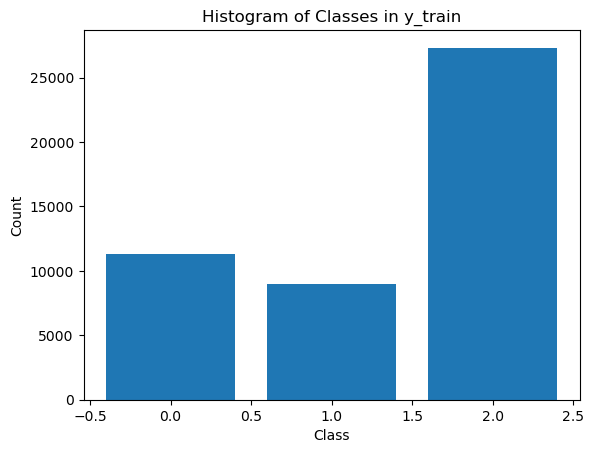

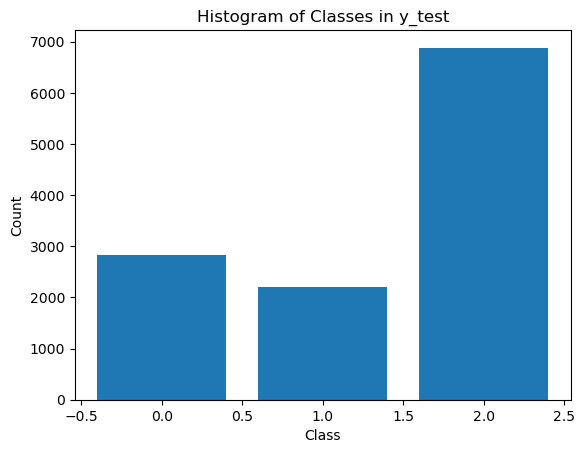

In [65]:
# plot a histogram for the three classes in y_train and y_test

# Plotting histogram for y_train
train_classes, train_counts = np.unique(y_train_class, return_counts=True)
plt.figure()
plt.bar(train_classes, train_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Histogram of Classes in y_train')
plt.show()

# Plotting histogram for y_test
test_classes, test_counts = np.unique(y_test_class, return_counts=True)
plt.figure()
plt.bar(test_classes, test_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Histogram of Classes in y_test')
plt.show()




In [66]:
# Baselines (XGB, naive)

if SKIP_DATA_LOADING == False: # no need to rerun with same data
    # XGB classification model
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
    xgb_model.fit(X_train, y_train_class)

    # Make predictions
    y_pred = xgb_model.predict(X_test)

    # Evaluate the model
    from sklearn.metrics import mean_squared_error

    rmse = np.sqrt(mean_squared_error(y_test_class, y_pred))
    xgb_accuracy = accuracy_score(y_test_class, y_pred)


    # Naive baseline
    y_pred = np.ones(len(y_test_class)) *  y_test_class.value_counts().index[0] # majority class

    rmse = np.sqrt(mean_squared_error(y_test_class, y_pred))

    naive_accuracy = accuracy_score(y_test_class, y_pred)
    
print("XGB baseline accuracy: {:.2f}%".format(xgb_accuracy * 100))
print("Naive baseline accuracy: {:.2f}%".format(naive_accuracy * 100))

XGB baseline accuracy: 87.45%
Naive baseline accuracy: 57.83%


In [67]:
# NN parameter optimization (Optuna)

if SKIP_OPTUNA == False:
    # convert boolean columns to scalar for NN
    X_train = convert_boolean_to_int(X_train)
    X_test = convert_boolean_to_int(X_test)

    X_train_retain, y_train_retain, X_train_forget, y_train_forget, y_train_mistakes = get_error_data(X_train, y_train_class, MISTAKE_PERCENTAGE)

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use "metal" if available, otherwise "cpu"
    DIR = os.getcwd()
    #EPOCHS = 10
    N_TRAIN_EXAMPLES = BATCHSIZE * 100000000 # unlimited
    N_VALID_EXAMPLES = BATCHSIZE * 100000000

    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=N_TRIALS, timeout=600, callbacks=[callback])

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    clear_output()
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    best_trial = study.best_trial

    print("  Value: ", best_trial.value)

    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))

    full_data_acc = best_trial.value * 100

# get epochs from trial object
EPOCHS = best_trial.params["epochs"]

# deepcopy best_trial as trial
use_trial = copy.deepcopy(best_trial)

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.8821304758903246
  Params: 
    n_layers: 3
    n_units: 100
    lr: 0.021368329072358756
    l2_pen: 1.152644954031562e-05
    epochs: 25


In [68]:
# Final lr
print("Starting lr: ", use_trial.params["lr"])
lr = use_trial.params["lr"]
final_lr = lr * gamma_ ** EPOCHS
print("Final lr: ", final_lr)

# going one further for finetuning
ft_lr = final_lr * gamma_
print("Finetuning lr: ", ft_lr)

Starting lr:  0.021368329072358756
Final lr:  0.005927351679708466
Finetuning lr:  0.005630984095723042


In [69]:
# get all the model parameters from Optuna here and pass them as dict to the training:
MODEL_base = define_model(use_trial).to(DEVICE)
LR = use_trial.params["lr"]
L2_PEN = use_trial.params["l2_pen"]


def run_experiment(RUN_NAME):

    # Logging: dataframe with columns SSD, Mistake, Best and 10 rows filled with nan
    results = pd.DataFrame(columns=['SSD', 'Mistake', 'Best', "ft_SSD", "ft_Mistake" ], index=range(ITERATIONS))
    results_raw = pd.DataFrame(columns=['SSD', 'Mistake', 'Best', "ft_SSD", "ft_Mistake", "rt_Best", "rt_SSD", "rt_Mistake", "ft_rt_SSD", "ft_rt_Mistake"], index=range(ITERATIONS))

    # create a dictionary to collect lists of alphas
    alpha_dict = dict()

    for run_i in range(ITERATIONS):
        # set random seeds for random, numpy and torch
        SEED = run_i
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        random.seed(SEED)
        sampler = TPESampler(seed=SEED) 

        clear_output() # done here to leave the print statements out for longer to read

        print(results)
        # print the mean of the results dataframe
        print("Mean: ")
        print(results.mean())

        print("Median: ")
        print(results.median())

        # print the raw mean and median
        print("Raw Mean: ")
        print(results_raw.mean())

        print("Raw Median: ")
        print(results_raw.median())

        print(RUN_NAME, "Starting Iteration: ", run_i+1, "/", ITERATIONS)

        # ---------------- Add errors to the data ----------------
        X_train_retain, y_train_retain, X_train_forget, y_train_forget, y_train_mistakes = get_error_data(X_train, y_train_class, MISTAKE_PERCENTAGE, error_scenario = ERROR_SCENARIO)

        wrong_share = (len(y_train_forget)/(len(y_train_forget) + len(y_train_retain)))*100
        print("Share of wrong labels: {:.2f}%".format(wrong_share))
        # in abslute numbers
        print("Number of wrong labels: ", len(y_train_forget))



        

        # ---------------- Train the mistake model ----------------

        # Train a neural network with the best hyperparameters we determined on the data with mistakes
        model = []
        MODEL = copy.deepcopy(MODEL_base)
        trial = []
        mistake_model, mistake_accuracy = train_model(MODEL, trial, DEVICE, X_train, y_train_mistakes, 
                                        BATCHSIZE, EPOCHS, N_TRAIN_EXAMPLES, N_VALID_EXAMPLES, X_test, y_test_class, optuna=False, lr=LR, l2_pen=L2_PEN)
        

        # get model accuracy on the retain data
        y_pred = mistake_model(torch.tensor(X_train_retain.values, dtype=torch.float32).to(DEVICE))
        y_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
        rt_mistake_accuracy = accuracy_score(y_train_retain, y_pred)
        
        mistake_save_model = copy.deepcopy(mistake_model)
        # Alternatively add one epoch of retraining
        if fine_tune_on:
            trial = copy.deepcopy(best_trial)
            ft_mistake_model, ft_mistake_accuracy = train_model(mistake_model, trial, DEVICE, X_train_retain, y_train_retain, 
                                            BATCHSIZE, 1, N_TRAIN_EXAMPLES, N_VALID_EXAMPLES, X_test, y_test_class, optuna=False, use_existing_model = True, ft_lr = ft_lr, lr=LR, l2_pen=L2_PEN)

        # get model accuracy on the retain data
        y_pred = ft_mistake_model(torch.tensor(X_train_retain.values, dtype=torch.float32).to(DEVICE))
        y_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
        ft_rt_mistake_accuracy = accuracy_score(y_train_retain, y_pred)

        # ---------------- Perform unlearning ----------------

        ssd_model = copy.deepcopy(mistake_save_model)
        ssd_model.to(DEVICE)

        retain = get_custom_dataset(X_train_retain, y_train_retain)
        forget = get_custom_dataset(X_train_forget, y_train_forget)

        
        # Start the time
        start_time = time.time()
        
        _, alph_list = ssd(ssd_model, retain, forget, alpha=ALPHA, lambda_param=LAMBDA_PARAM)

        # Record the end time
        end_time = time.time()

        # add alph_list list to alpha_dict with index of the iteration
        alpha_dict[run_i] = alph_list

        # Make predictions
        ssd_model.to(DEVICE)

        # REAL LIFE SAFETY STEP (not used in the paper but can be used in real life for extra robustness)
        # Test on retain data if we think this model should be favoured:
        y_pred = ssd_model(torch.tensor(X_train_retain.values, dtype=torch.float32).to(DEVICE))
        y_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
        ssd_expected_accuracy = accuracy_score(y_train_retain, y_pred)

        y_pred = mistake_model(torch.tensor(X_train_retain.values, dtype=torch.float32).to(DEVICE))
        y_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
        mistake_expected_accuracy = accuracy_score(y_train_retain, y_pred)


        # Calculate the elapsed time
        elapsed_time = end_time - start_time
       

        if ssd_expected_accuracy > mistake_expected_accuracy * TOLERANCE:
            y_pred = ssd_model(torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE))
            y_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()

            # Evaluate the model accuracy
            ssd_accuracy = accuracy_score(y_test_class, y_pred)
        else:
            ssd_accuracy = mistake_accuracy/100
        
        ssd_accuracy = ssd_accuracy * 100 # already done for other trainings in the train_model function


        # get model accuracy on the retain data
        y_pred = ssd_model(torch.tensor(X_train_retain.values, dtype=torch.float32).to(DEVICE))
        y_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
        rt_ssd_accuracy = accuracy_score(y_train_retain, y_pred)

        # Alternatively add one epoch of retraining
        if fine_tune_on:
            trial = copy.deepcopy(best_trial)
            ft_ssd_model, ft_ssd_accuracy = train_model(ssd_model, trial, DEVICE, X_train_retain, y_train_retain, 
                                            BATCHSIZE, 1, N_TRAIN_EXAMPLES, N_VALID_EXAMPLES, X_test, y_test_class, optuna=False, use_existing_model = True, ft_lr = ft_lr, lr=LR, l2_pen=L2_PEN)

        # get model accuracy on the retain data
        y_pred = ft_ssd_model(torch.tensor(X_train_retain.values, dtype=torch.float32).to(DEVICE))
        y_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
        ft_rt_ssd_accuracy = accuracy_score(y_train_retain, y_pred)



        # ---------------- Train the correct model ----------------

        # Train a neural network with the best hyperparameters we determined on the data without mistakes
        
        model = []
        MODEL = copy.deepcopy(MODEL_base)
        trial = []
        #  on correct data
        best_model, best_accuracy = train_model(MODEL, trial, DEVICE, X_train_retain, y_train_retain, 
                                        BATCHSIZE, EPOCHS, N_TRAIN_EXAMPLES, N_VALID_EXAMPLES, X_test, y_test_class, optuna=False, lr=LR, l2_pen=L2_PEN)
        
        # get model accuracy on the retain data
        y_pred = best_model(torch.tensor(X_train_retain.values, dtype=torch.float32).to(DEVICE))
        y_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
        rt_best_accuracy = accuracy_score(y_train_retain, y_pred)

        # Add everything to the logging dataframe
        results_raw.loc[run_i, 'SSD'] = ssd_accuracy
        results_raw.loc[run_i, 'Mistake'] = mistake_accuracy
        results_raw.loc[run_i, 'Best'] = best_accuracy

        results_raw.loc[run_i, 'rt_SSD'] = rt_ssd_accuracy * 100
        results_raw.loc[run_i, 'rt_Mistake'] = rt_mistake_accuracy * 100
        results_raw.loc[run_i, 'rt_Best'] = rt_best_accuracy * 100
        results_raw.loc[run_i, 'ft_rt_SSD'] = ft_rt_ssd_accuracy * 100
        results_raw.loc[run_i, 'ft_rt_Mistake'] = ft_rt_mistake_accuracy * 100

        results_raw.loc[run_i, 'ft_SSD'] = ft_ssd_accuracy
        results_raw.loc[run_i, 'ft_Mistake'] = ft_mistake_accuracy

        
        if True: # Make it all relative to the performance of the mistake model
            results.loc[run_i, 'SSD'] = ssd_accuracy - mistake_accuracy
            results.loc[run_i, 'Best'] = best_accuracy - mistake_accuracy
            results.loc[run_i, 'Mistake'] = mistake_accuracy #* 0 ????????? WTF

            results.loc[run_i, 'ft_SSD'] = ft_ssd_accuracy - mistake_accuracy
            results.loc[run_i, 'ft_Mistake'] = ft_mistake_accuracy - mistake_accuracy
        else:
            results.loc[run_i, 'SSD'] = ssd_accuracy
            results.loc[run_i, 'Best'] = best_accuracy
            results.loc[run_i, 'Mistake'] = mistake_accuracy

            results.loc[run_i, 'ft_SSD'] = ft_ssd_accuracy
            results.loc[run_i, 'ft_Mistake'] = ft_mistake_accuracy


        # Call clear_output() to clear the output of the current cell
        print(f"SSD Elapsed time: {elapsed_time} seconds")
        #print("ALPHA: ", ALPHA)
        
        print(RUN_NAME, "Iteration: ", run_i+1, "/", ITERATIONS)
        print(results)

        # print the mean of the results dataframe
        print("Mean: ")
        print(results.mean())

        print("Median: ")
        print(results.median())

        # print the raw mean and median
        print("Raw Mean: ")
        print(results_raw.mean())

        print("Raw Median: ")
        print(results_raw.median())

    # ------------------ Calculating additional columns ------------------
    # multiply each column by 100 for percentage
    results = results #* 100

    results["Delta to Best"] = (results["Mistake"] - results["Best"])
    results["Gain"] = (results["SSD"] - results["Mistake"])/results["Mistake"] * 100

    results["Base Gap"] = results["Mistake"] -results["Best"] 
    results["SSD Gap"] =  results["SSD"] - results["Best"] 

    # number of samples in test data
    n = len(y_test_class)

    print("total test cases: ", n)

    # ------------------ Same for raw (put in a loop in the future) ------------------
    # multiply each column by 100 for percentage
    results_raw = results_raw #* 100

    results_raw["Delta to Best"] = (results_raw["Mistake"] - results_raw["Best"])
    results_raw["Gain"] = (results_raw["SSD"] - results_raw["Mistake"])/results_raw["Mistake"] * 100

    results_raw["Base Gap"] = results_raw["Mistake"] -results_raw["Best"] 
    results_raw["SSD Gap"] =  results_raw["SSD"] - results_raw["Best"] 

    # number of samples in test data
    n = len(y_test_class)

    print("total test cases: ", n)
    results_raw["Add corr classifications"] = n * results_raw["Gain"] / 100
    results_raw["Num gap to best"] = -n * results_raw["Base Gap"] / 100
    # cut off the decimal places
    results_raw["Add corr classifications"] = results_raw["Add corr classifications"].astype(int)
    results_raw["Num gap to best"] = results_raw["Num gap to best"].astype(int)

    results_raw["Gap closed"] = results_raw["Add corr classifications"]/results_raw["Num gap to best"] * 100

    # copy in
    results["Add corr classifications"] =  results_raw["Add corr classifications"]
    results["Num gap to best"] =  results_raw["Num gap to best"]
    results["Gap closed"] =  results_raw["Gap closed"]
    # ------------------ Summary ------------------
    # create a new dataframe with the same column names and first row mean of the results dataframe, second row std of the results dataframe
    summary = pd.DataFrame(columns=results.columns, index=['mean', 'std'])

    # fill the first row with the mean of the results dataframe
    summary.loc['mean'] = results.mean()
    summary.loc['median'] = results.median()

    # fill the second row with the std of the results dataframe
    summary.loc['std'] = results.std()

    clear_output()
    
    get_plots(results, RUN_NAME)
    get_plots(results, RUN_NAME, delta=True)

    # save the results dataframe to csv using the name from the variable RUN_NAME
    results.to_csv(FOLDER_PREFIX+'results/log_' + RUN_NAME + '.csv')
    results_raw.to_csv(FOLDER_PREFIX+'results/log_raw_' + RUN_NAME + '.csv')

    # hacky modification to get the same plot on the retain set
    if True:
        results_raw["Mistake"] = results_raw["rt_Mistake"]
        results_raw["Best"] = results_raw["rt_Best"]
        results_raw["ft_Mistake"] = results_raw["ft_rt_Mistake"]
        results_raw["SSD"] = results_raw["rt_SSD"]
        results_raw["ft_SSD"] = results_raw["ft_rt_SSD"]

    get_plots(results_raw, RUN_NAME, prefix = "rt_")
    get_plots(results, RUN_NAME, prefix = "rt_", delta=True)

    summary.head()

    return results

In [70]:
def stat_sig_check(results_list, name_list):

    for results, name_ in zip(results_list, name_list):
        # Perform an independent samples t-test
        column1_data = pd.to_numeric(results['SSD'], errors='coerce') 
        column2_data = pd.to_numeric(results['Mistake'], errors='coerce') 

        t_statistic, p_value = stats.ttest_ind(column1_data, column2_data)

        # Output the results
        print(f'T-Statistic: {t_statistic}')
        print(f'P-Value: {p_value}')

        # Interpret the results
        alpha = 0.05  # Set your significance level (e.g., 0.05)
        print("RUN: ", name_)
        
        if p_value < alpha:
            print("Reject the null hypothesis: There is a significant difference between the two columns.")
            return "Significant"
        else:
            print("Fail to reject the null hypothesis: There is no significant difference between the two columns.")
            return "NOT Significant"

        

# Run and save experiments

In [71]:
# get error data for the baseline
X_train_retain, y_train_retain, X_train_forget, y_train_forget, y_train_mistakes = get_error_data(X_train, y_train_class, MISTAKE_PERCENTAGE, error_scenario = ERROR_SCENARIO)

# print shape of each
print("X_train_retain: ", X_train_retain.shape)
print("y_train_retain: ", y_train_retain.shape)
print("X_train_forget: ", X_train_forget.shape)
print("y_train_forget: ", y_train_forget.shape)
print("y_train_mistakes: ", y_train_mistakes.shape)

X_train_retain:  (47593, 28)
y_train_retain:  (47593,)
X_train_forget:  (0, 28)
y_train_forget:  (0,)
y_train_mistakes:  (47593,)


Share of runs where SSD is BETTER than Mistake: 0.00%
Share of runs where SSD is EQUAL to Mistake: 0.00%
Share of runs where SSD is WORSE than Mistake: 1.00%
Share of runs where SSD is BETTER than Mistake: 0.00%
Share of runs where SSD is EQUAL to Mistake: 0.00%
Share of runs where SSD is WORSE than Mistake: 1.00%
Share of runs where SSD is BETTER than Mistake: 0.67%
Share of runs where SSD is EQUAL to Mistake: 0.00%
Share of runs where SSD is WORSE than Mistake: 0.33%
Share of runs where SSD is BETTER than Mistake: 0.00%
Share of runs where SSD is EQUAL to Mistake: 0.00%
Share of runs where SSD is WORSE than Mistake: 1.00%


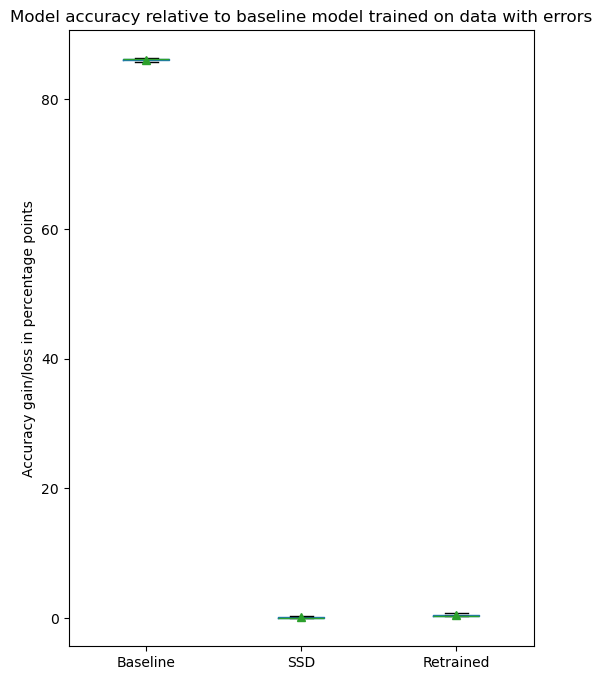

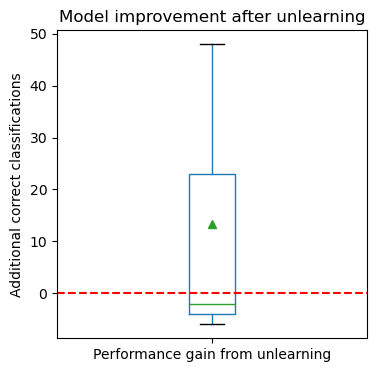

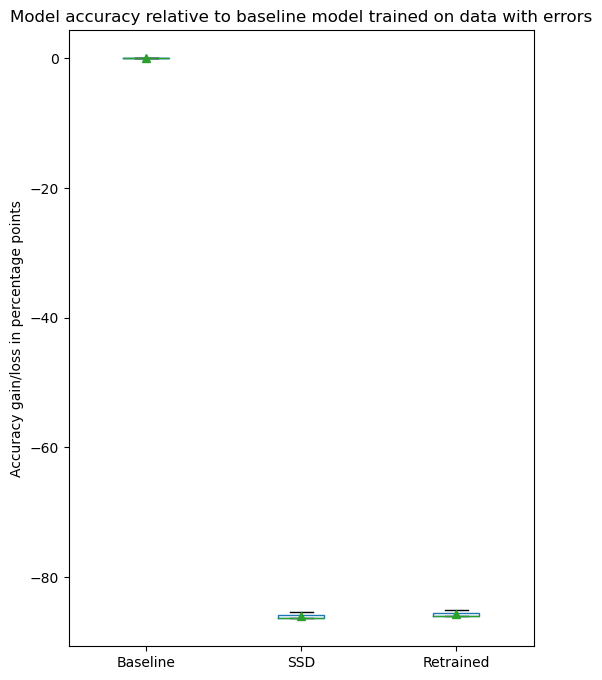

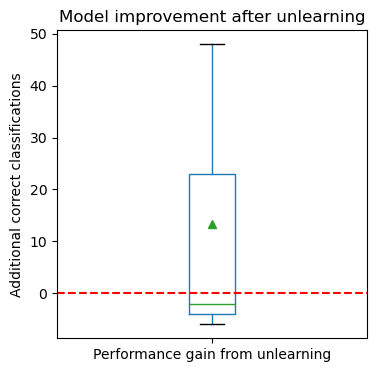

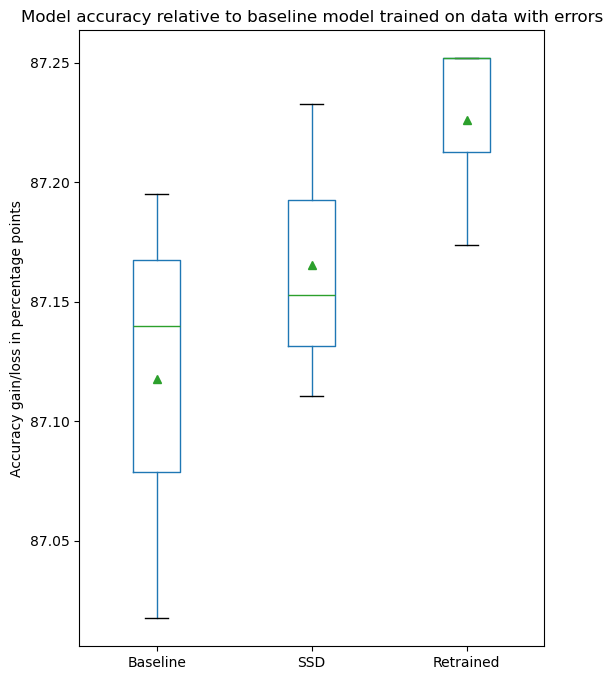

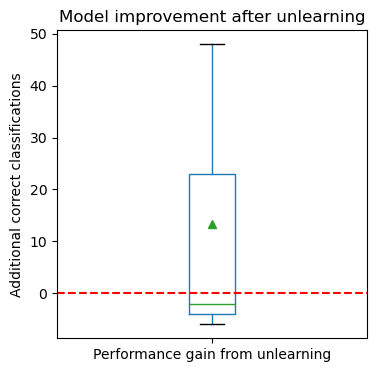

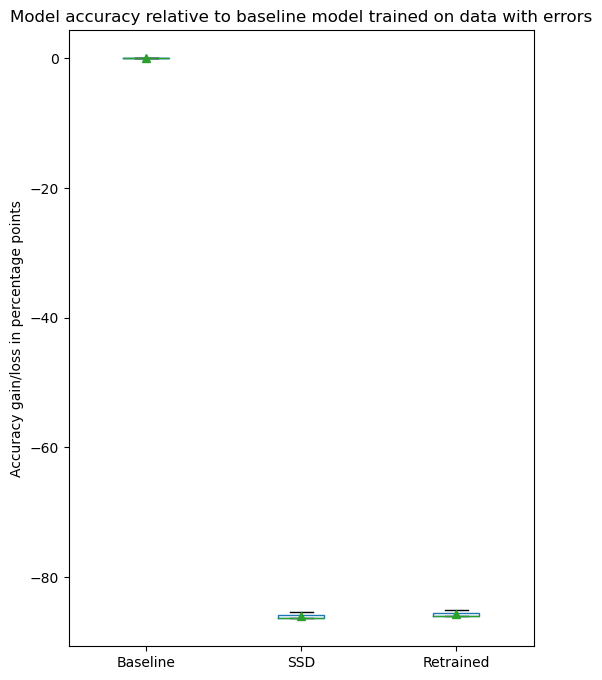

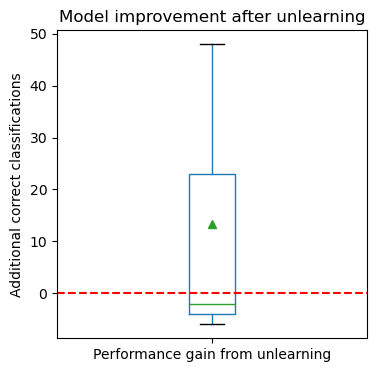

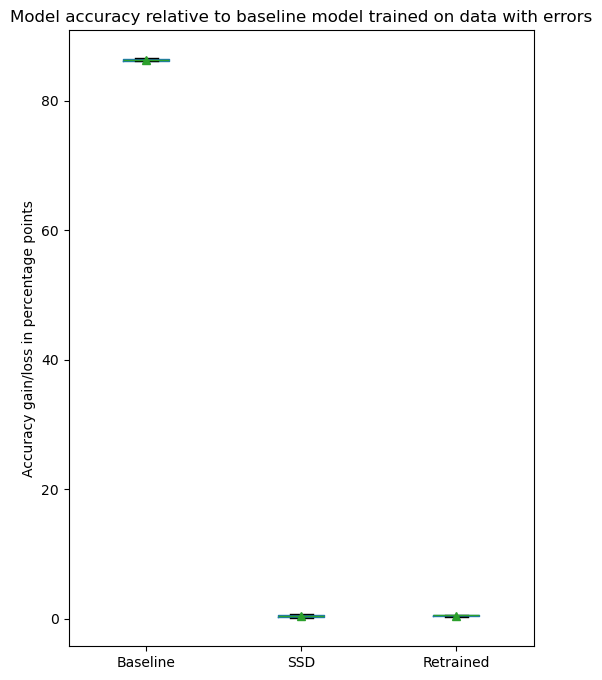

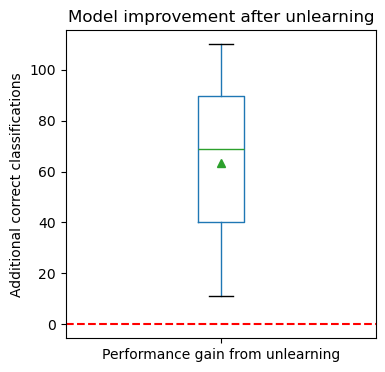

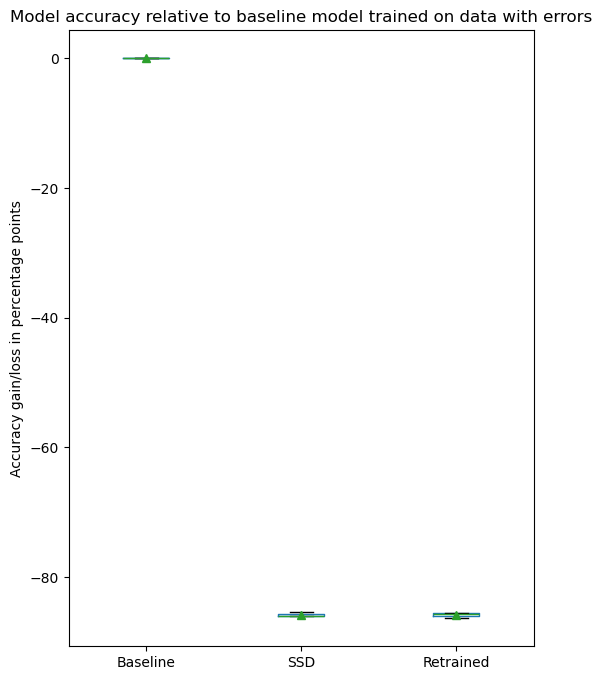

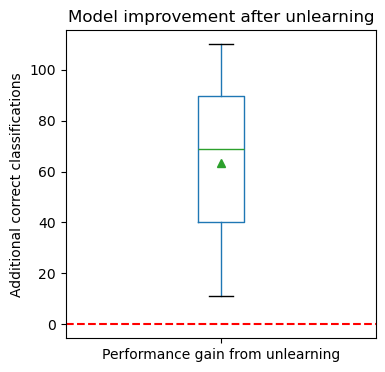

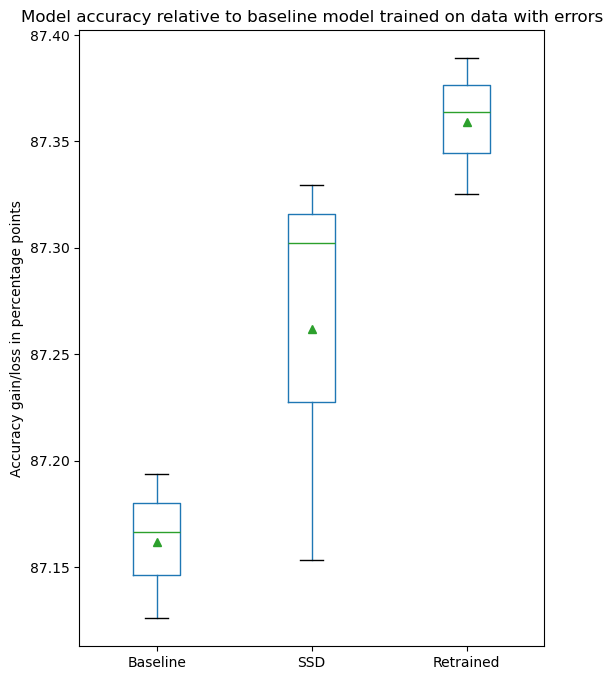

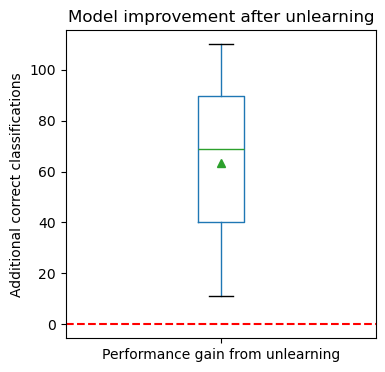

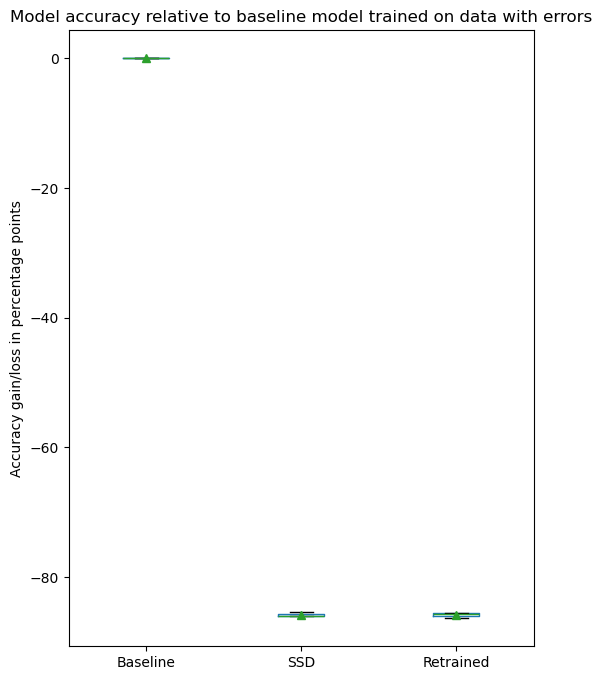

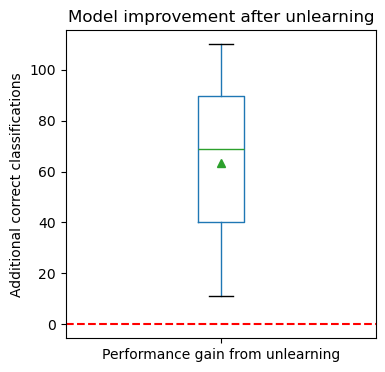

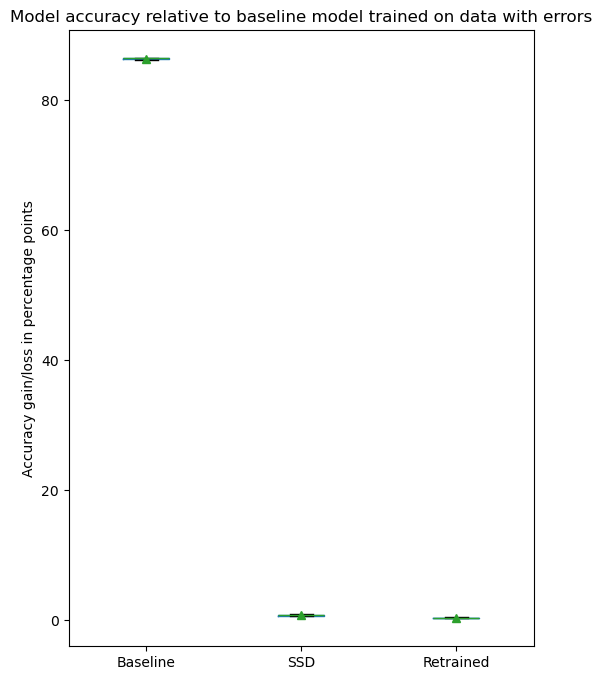

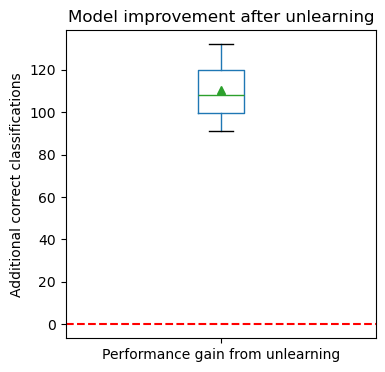

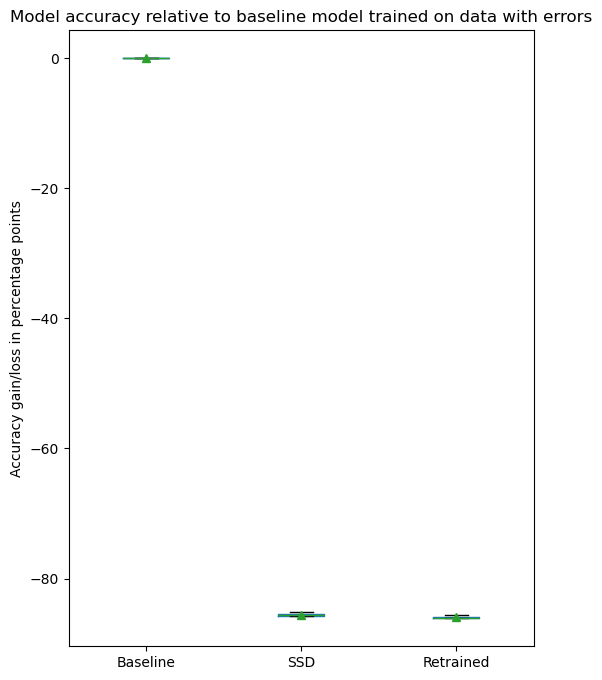

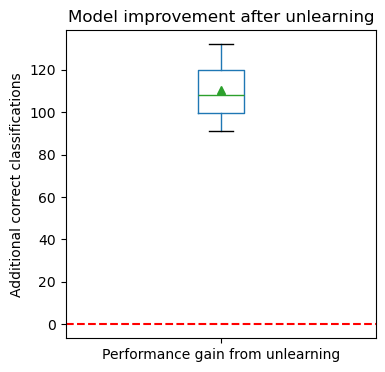

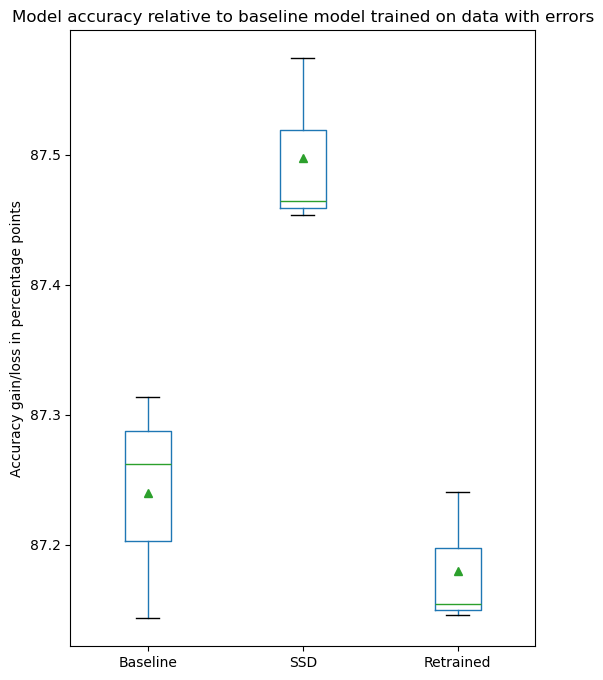

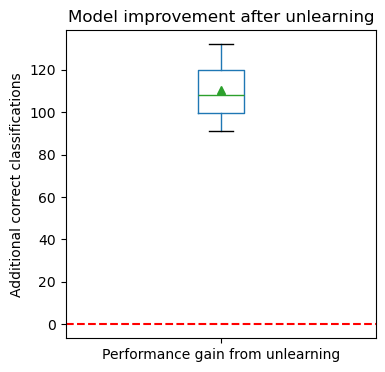

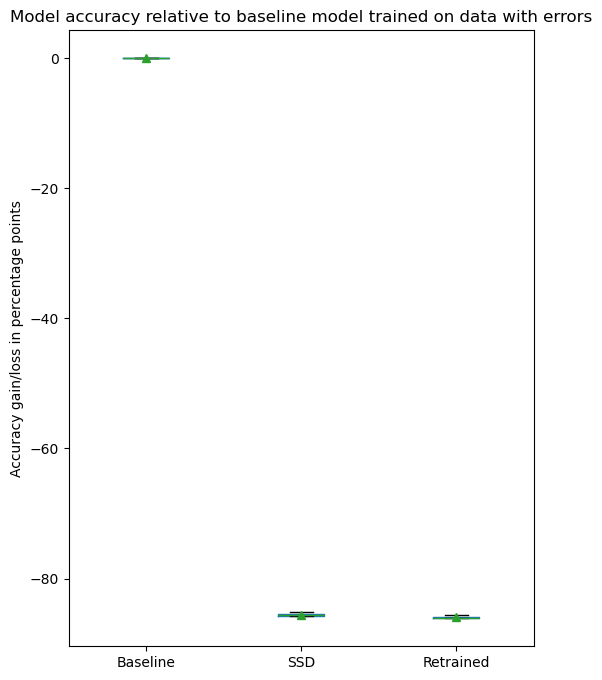

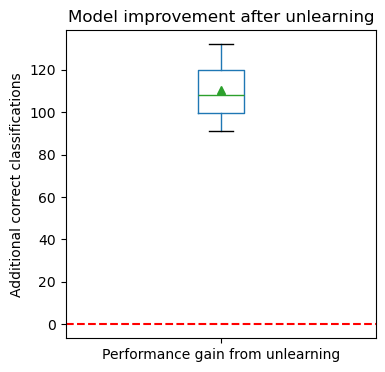

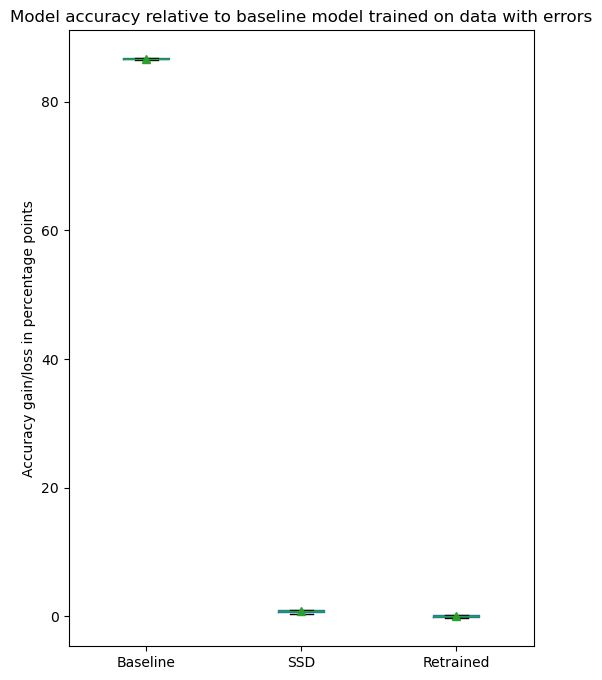

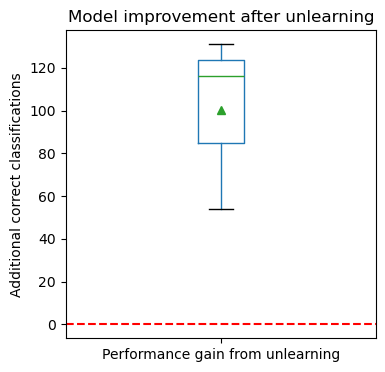

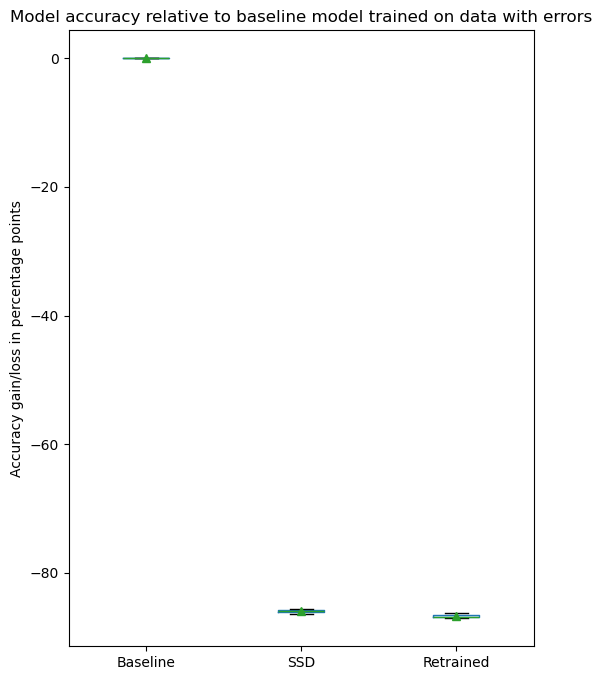

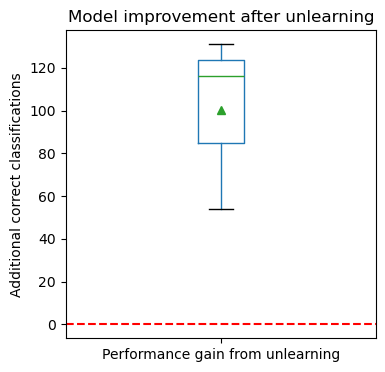

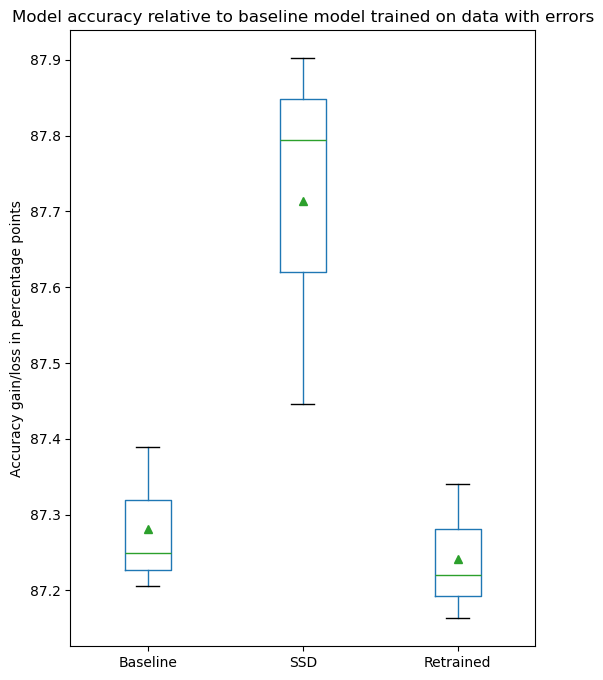

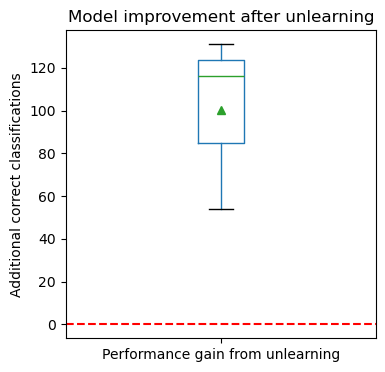

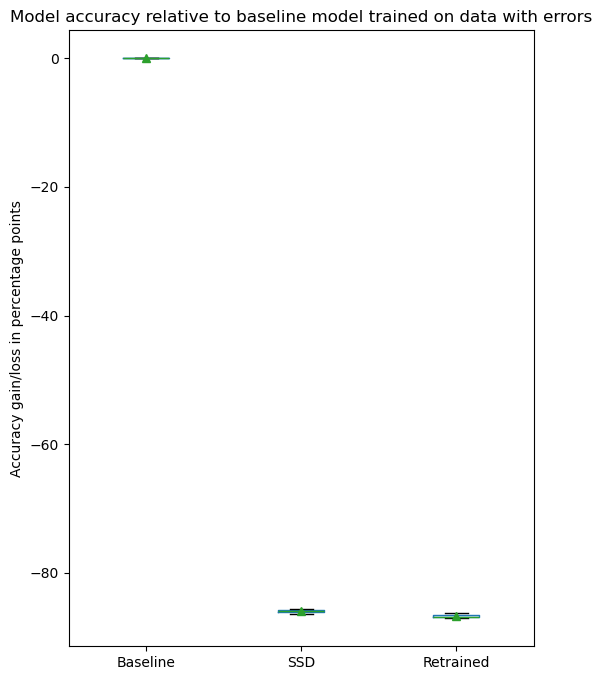

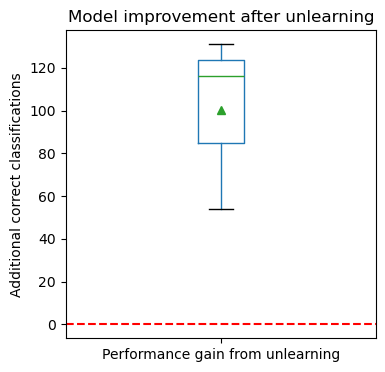

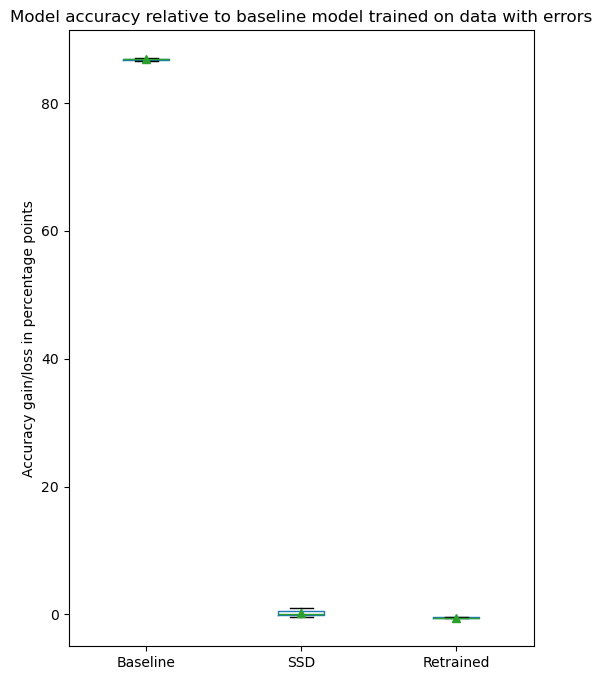

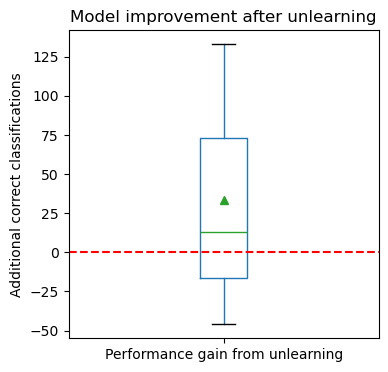

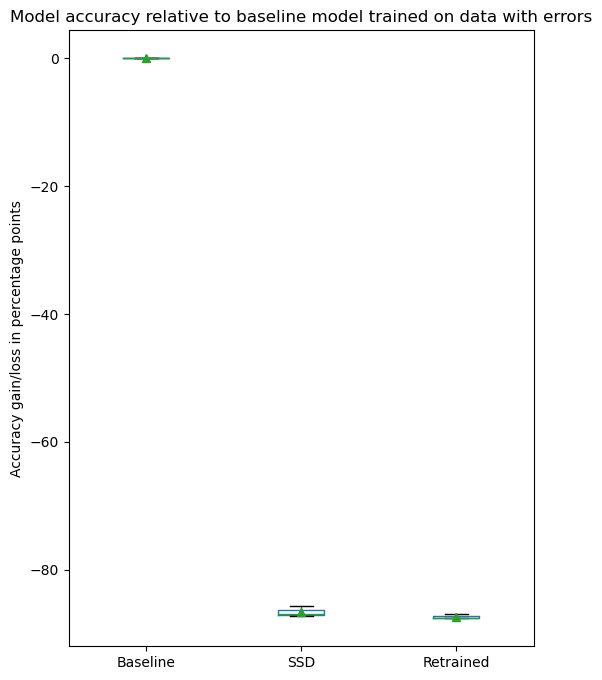

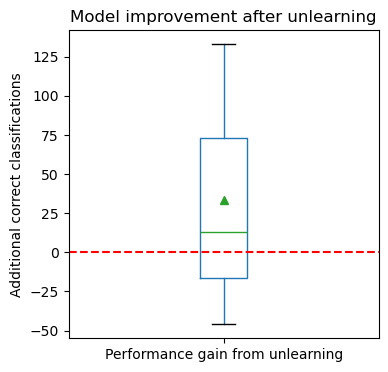

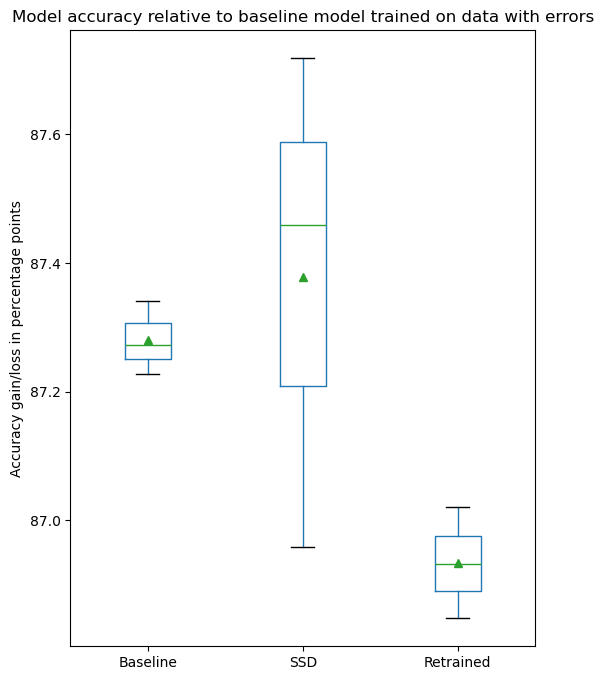

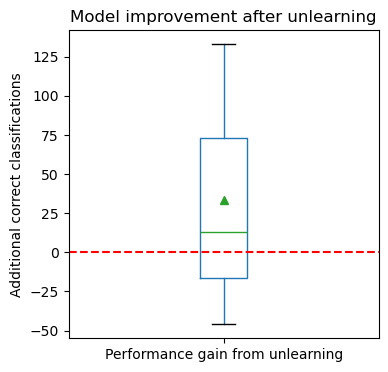

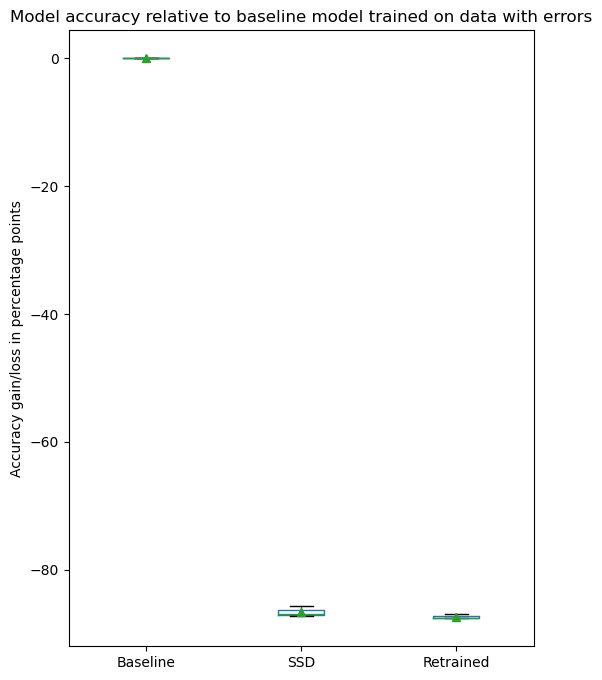

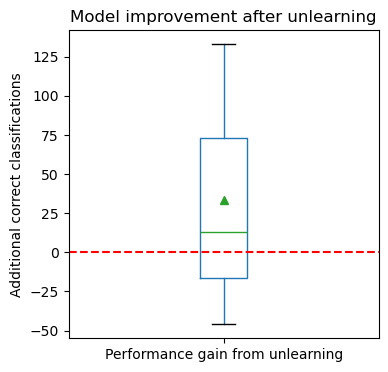

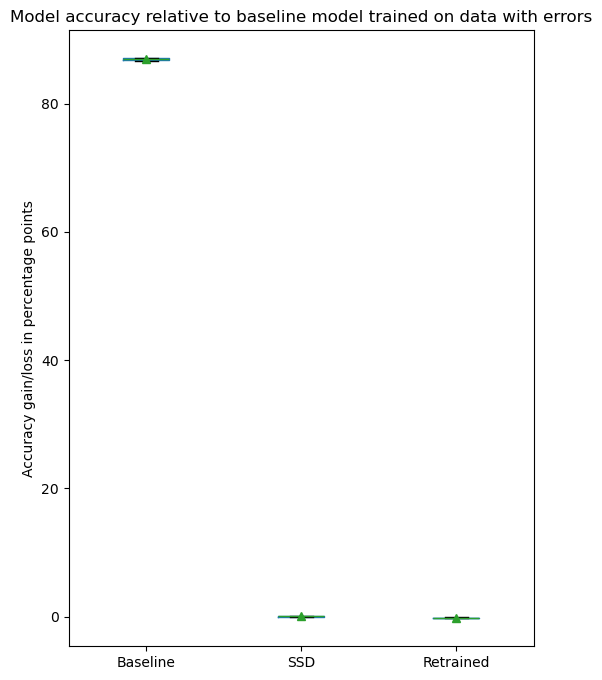

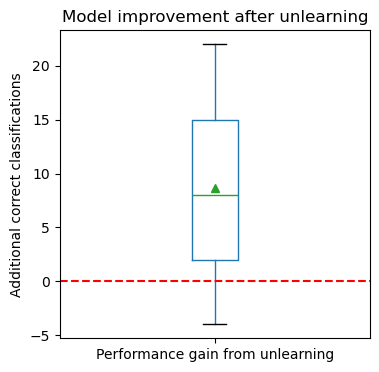

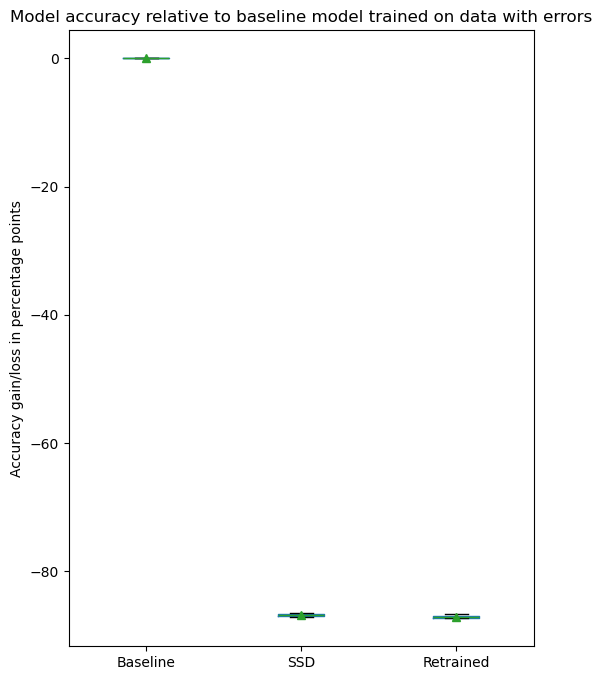

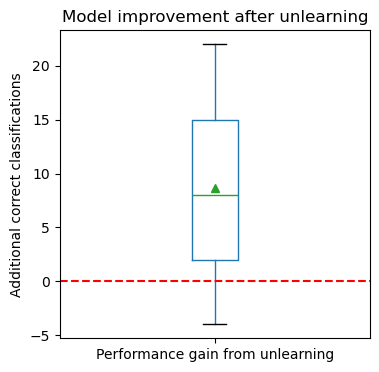

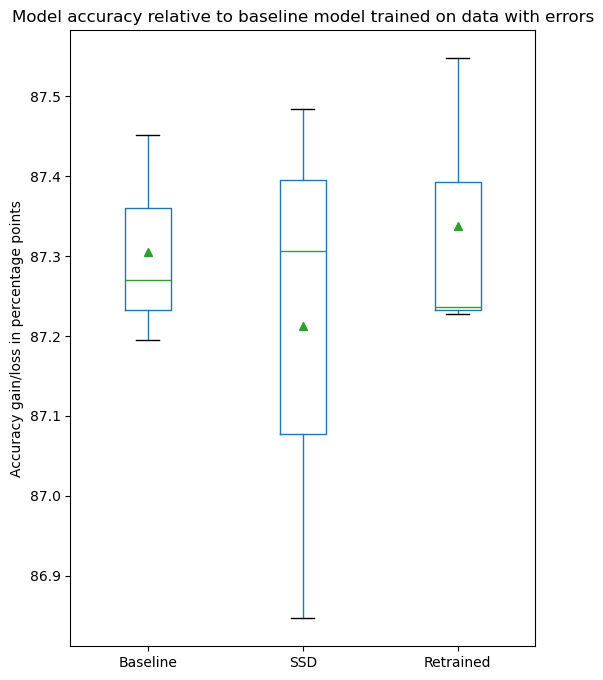

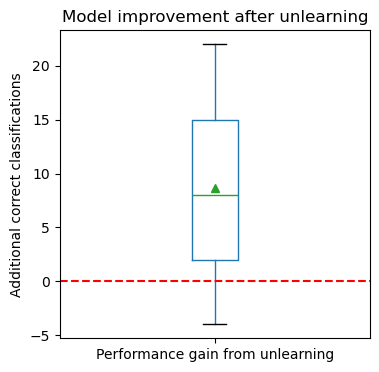

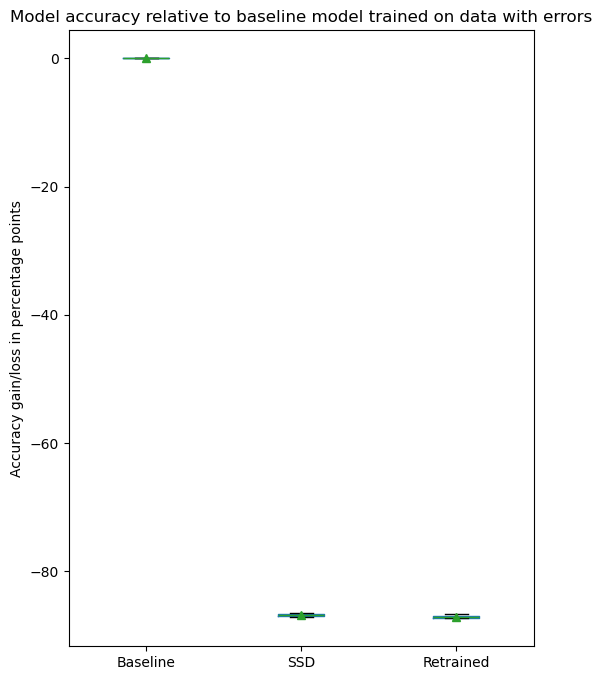

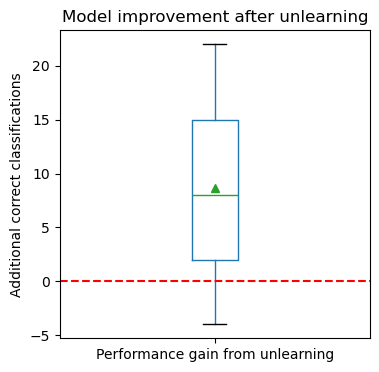

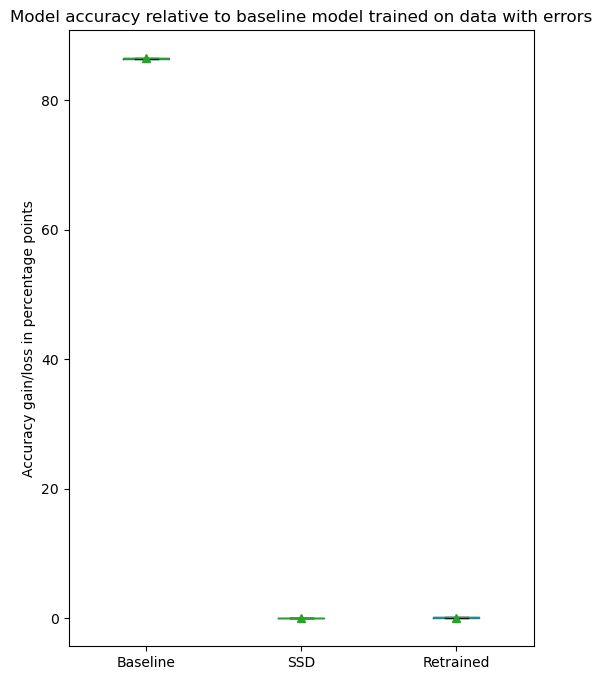

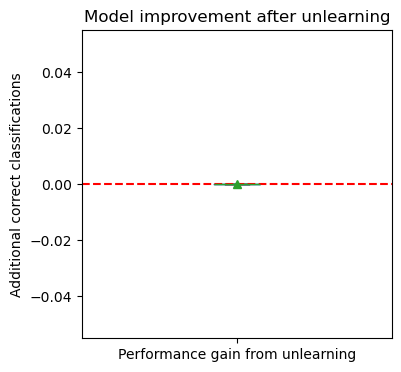

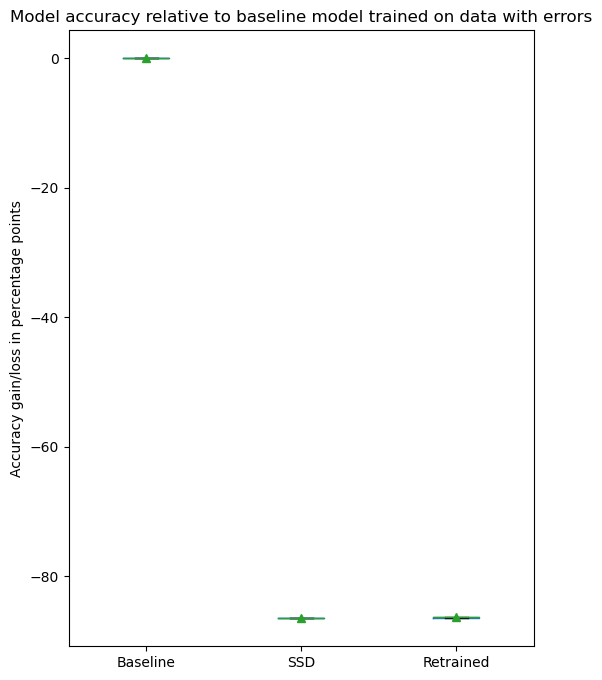

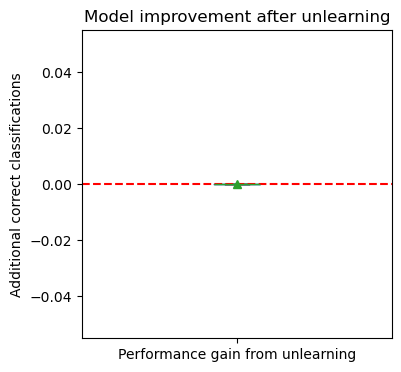

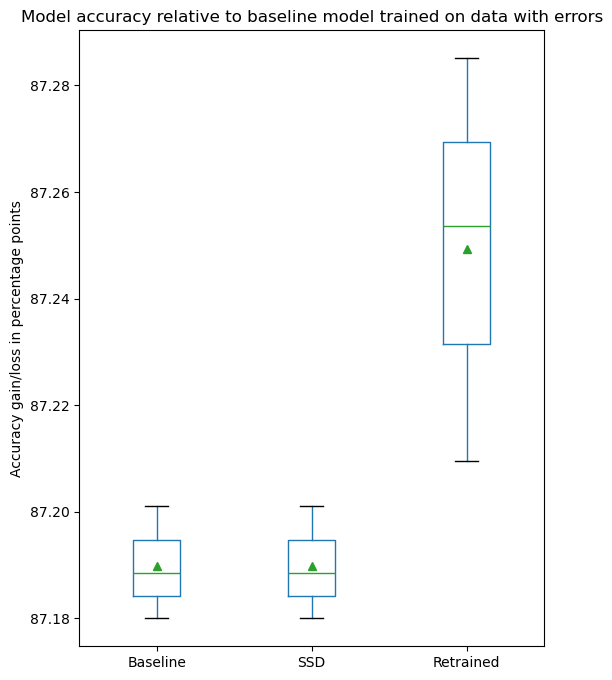

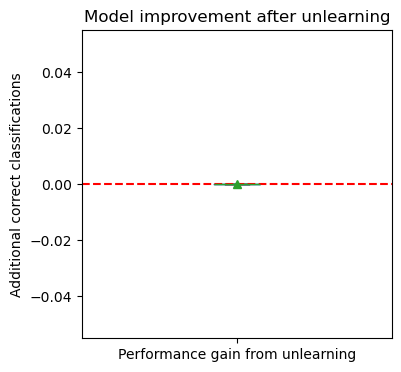

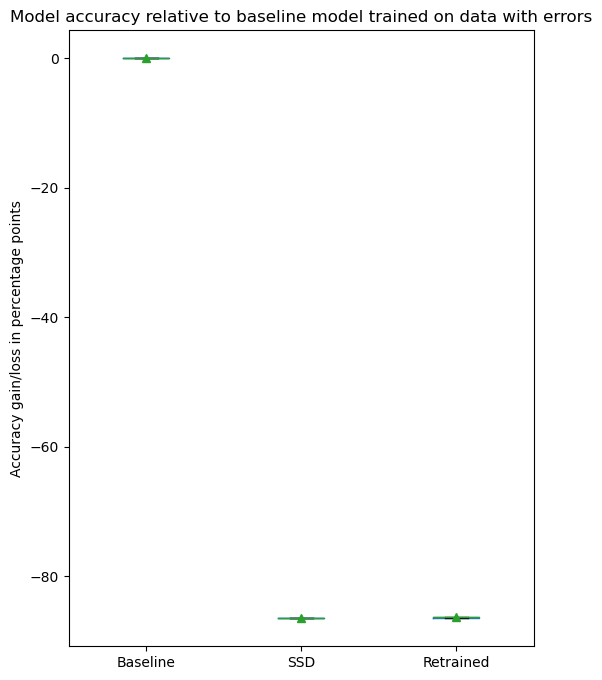

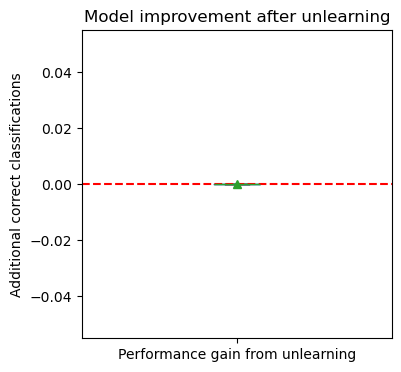

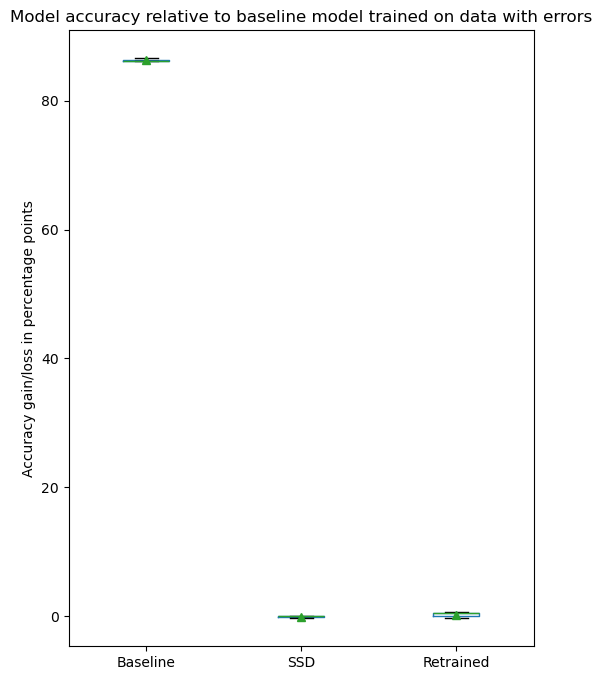

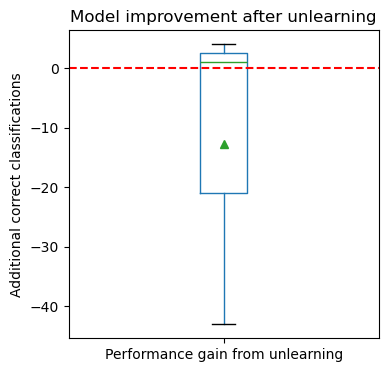

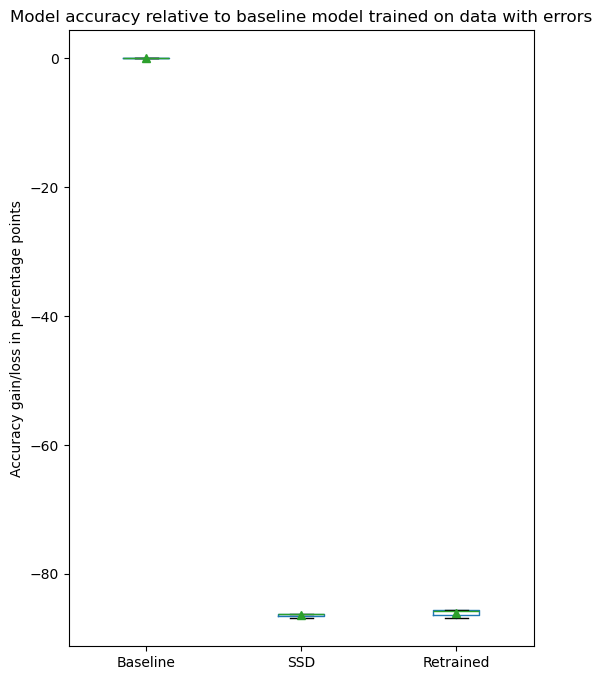

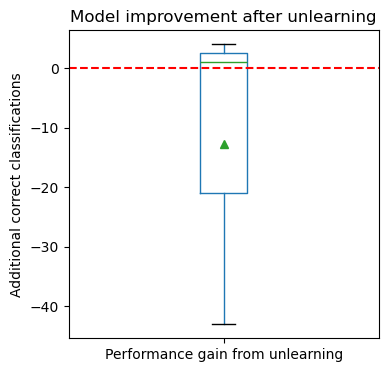

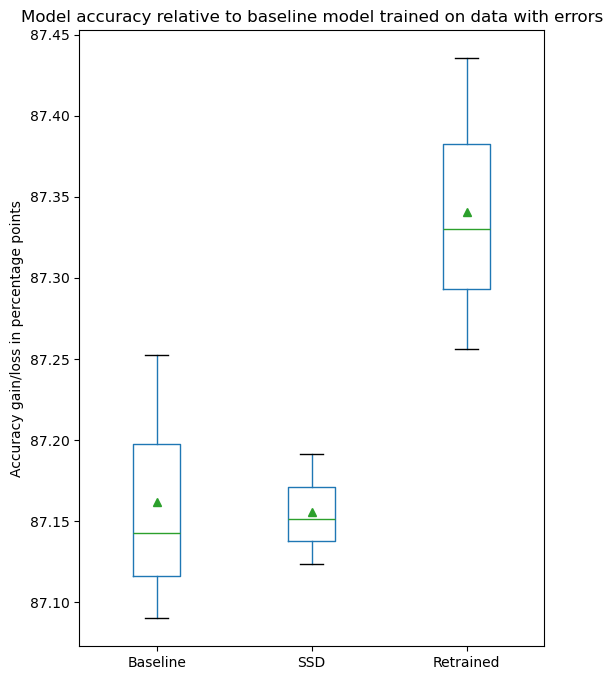

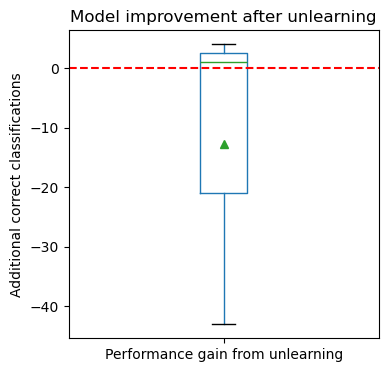

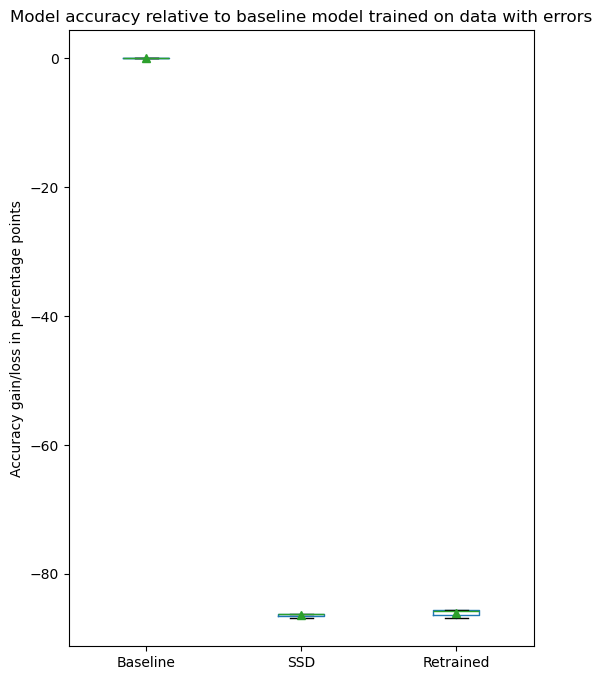

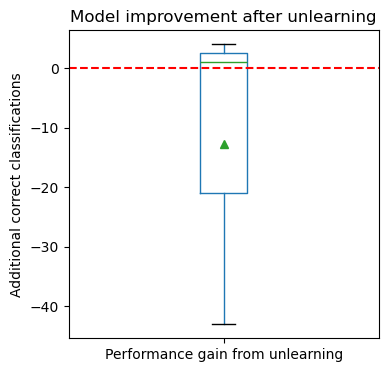

In [72]:
ITERATIONS = 3

fine_tune_on = True
mistake_percentages = [0.5, 1, 2.5, 5, 7.5, 10, 0.025, 0.25]
lambda_params = [1]
dampen_limits = [0]
tolerances = [0]
alphas = ["Adaptive"]

LAYER_SIZE_CUTOFF = 1 # 1 does nothing, could set higher to ignore layers with less than x parameters

total_iterations = len(mistake_percentages) * len(lambda_params) * len(dampen_limits) * len(tolerances) * len(alphas)

results_list = list()
name_list = list()


for MISTAKE_PERCENTAGE in mistake_percentages:
    for LAMBDA_PARAM in lambda_params:
        for DAMPEN_LIMIT in dampen_limits:
            for TOLERANCE in tolerances:
                for ALPHA in alphas:

                    # Combine the parameters into a run name string
                    RUN_NAME = f"{MISTAKE_PERCENTAGE}perc_a{ALPHA}_lam{LAMBDA_PARAM}_tol{TOLERANCE}_damplim{DAMPEN_LIMIT}"
                    #print(RUN_NAME)
                    results = run_experiment(RUN_NAME)
                    results_list.append(results)
                    name_list.append(RUN_NAME)

                    
    
